# Imports

In [1]:
import os
import string
import time
import unicodedata

import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from warnings import filterwarnings

%matplotlib inline
filterwarnings('ignore')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
torch.__version__

'0.4.1'

# Introduction 

In this notebook, we will be training a RNN using dataset of names from 18 different languages. When training is done, our RNN should be able to classify the name into one of the 18 different languages. Below are the languages:

In [3]:
PATH = Path('../data/names/')
languages = sorted([fname.stem for fname in PATH.glob('*.txt')])
languages

['Arabic',
 'Chinese',
 'Czech',
 'Dutch',
 'English',
 'French',
 'German',
 'Greek',
 'Irish',
 'Italian',
 'Japanese',
 'Korean',
 'Polish',
 'Portuguese',
 'Russian',
 'Scottish',
 'Spanish',
 'Vietnamese']

# Data Exploration

In [4]:
!ls {PATH}

Arabic.txt     English.txt    Irish.txt      Polish.txt     Spanish.txt
Chinese.txt    French.txt     Italian.txt    Portuguese.txt Vietnamese.txt
Czech.txt      German.txt     Japanese.txt   Russian.txt
Dutch.txt      Greek.txt      Korean.txt     Scottish.txt


In [5]:
%%bash
cd ../data/names/
wc -l *.txt| sort -r

   20074 total
    9408 Russian.txt
    3668 English.txt
    2000 Arabic.txt
     991 Japanese.txt
     724 German.txt
     709 Italian.txt
     519 Czech.txt
     298 Spanish.txt
     297 Dutch.txt
     277 French.txt
     268 Chinese.txt
     232 Irish.txt
     203 Greek.txt
     139 Polish.txt
     100 Scottish.txt
      94 Korean.txt
      74 Portuguese.txt
      73 Vietnamese.txt


In [6]:
!head -5 {PATH  / 'Arabic.txt'}

Khoury
Nahas
Daher
Gerges
Nazari


In [7]:
# Create vocabulary
vocab = string.ascii_lowercase + " .,;'"
vocab_size = len(vocab)

# Create characters to indices and vise versa
char_idx = {char: i for i, char in enumerate(vocab)}
idx_char = {i: char for i, char in enumerate(vocab)}
print(f'Vocabulary dictionary : {vocab}\n')
print(f'Vocabulary size : {vocab_size}\n')
print(char_idx, end='\n\n')
print(idx_char)

Vocabulary dictionary : abcdefghijklmnopqrstuvwxyz .,;'

Vocabulary size : 31

{'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6, 'h': 7, 'i': 8, 'j': 9, 'k': 10, 'l': 11, 'm': 12, 'n': 13, 'o': 14, 'p': 15, 'q': 16, 'r': 17, 's': 18, 't': 19, 'u': 20, 'v': 21, 'w': 22, 'x': 23, 'y': 24, 'z': 25, ' ': 26, '.': 27, ',': 28, ';': 29, "'": 30}

{0: 'a', 1: 'b', 2: 'c', 3: 'd', 4: 'e', 5: 'f', 6: 'g', 7: 'h', 8: 'i', 9: 'j', 10: 'k', 11: 'l', 12: 'm', 13: 'n', 14: 'o', 15: 'p', 16: 'q', 17: 'r', 18: 's', 19: 't', 20: 'u', 21: 'v', 22: 'w', 23: 'x', 24: 'y', 25: 'z', 26: ' ', 27: '.', 28: ',', 29: ';', 30: "'"}


In [8]:
def unicode_to_ascii(s, vocab):
    '''Convert a unicode string to ascii.'''
    res = []
    for c in unicodedata.normalize('NFD', s.lower()):
        if unicodedata.category(c) != 'Mn' and c in vocab:
            res.append(c)
    return ''.join(res)

unicode_to_ascii('Ślusàrski', vocab)

'slusarski'

In [9]:
def read_file(fname, vocab):
    '''Read file, split lines into words, and convert them to ascii.'''
    with open(fname, 'r', encoding='utf-8') as f:
        names = f.read().strip().lower().split('\n')
        names_ascii = [unicode_to_ascii(name, vocab) for name in names]
    return names_ascii

In [12]:
# Get the data
languages = []
language_names = {}

for fname in list(PATH.glob('*.txt')):
    language = fname.stem
    languages.append(language)
    names = read_file(fname, vocab)
    language_names[language] = names

n_classes = len(languages)
vocab_size, n_classes, language_names['Arabic'][:5]

(31, 18, ['khoury', 'nahas', 'daher', 'gerges', 'nazari'])

In [13]:
def name_to_tensor(name, vocab_size):
    '''Convert name into tensor of one-hot encoding.'''
    idxs = [char_idx[char] for char in name]
    name_tensor = torch.zeros(len(name), 1, vocab_size)
    for t in range(len(name)):
        name_tensor[t][0][idxs[t]] = 1
    
    return name_tensor

In [15]:
name_to_tensor('abcd', vocab_size)

tensor([[[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]])

# RNN

In [98]:
class RNN(nn.Module):
    '''Creating one hidden layer RNN.'''
    
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.input_to_hidden = nn.Linear(self.input_size + self.hidden_size,
                                         self.hidden_size)
        self.input_to_output = nn.Linear(self.input_size + self.hidden_size,
                                         self.output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, input_word, hidden_state):
        combined = torch.cat([hidden_state, input_word], 1)
        hidden_state = self.input_to_hidden(combined)
        output = self.input_to_output(combined)
        output = self.softmax(output)
        return output, hidden_state
    
    def initialize_hidden_state(self):
        return torch.zeros(1, self.hidden_size)

# Training

In [99]:
def names_dataloader(language_names, vocab_size):
    '''Loading name and language as tensors to be used in RNN training.'''
    # Randomly select a language and then create 1-D tensor
    languages = list(language_names.keys())
    n_classes = len(languages)
    language = np.random.choice(languages)
#     label_tensor = torch.zeros(1, n_classes, dtype=torch.int64)
#     label_tensor[:, languages.index(language)] = 1
    label_tensor = torch.tensor([languages.index(language)], dtype=torch.int64)
    
    # Get a random name from the language above
    name = np.random.choice(language_names[language])
    name_tensor = name_to_tensor(name, vocab_size)
    
    return name, language, name_tensor, label_tensor

In [100]:
names_dataloader(language_names, vocab_size)

('klein',
 'Dutch',
 tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
 
         [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
 
         [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
 
         [[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
 
         [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]]),
 tensor([15]))

In [121]:
# Split data into 80% training and 20% validation
training_data = {}
valid_data = {}

for language, names in language_names.items():
    size = len(names)
    train_size = int(size * 0.8)
    shuffled_idxs = np.random.permutation(range(size))
    names = list(np.array(names)[shuffled_idxs])
    training_data[language] = names[:train_size]
    valid_data[language] = names[train_size:]

In [122]:
# Instantiate the model
hidden_size = 128
rnn = RNN(vocab_size, hidden_size, n_classes)

# Loss and optimizer
criterion = nn.NLLLoss()
optimizer = optim.Adam(rnn.parameters())

In [123]:
n_iterations = 100000
start = time.time()
total_loss = []
current_loss = 0
for i in range(n_iterations):
    # Initialize hidden state to zero
    hidden_state = rnn.initialize_hidden_state()
    
    # Get name and label tensors
    _, _, name_tensor, label_tensor = names_dataloader(training_data, vocab_size)
    
    # Zeros gradients
    optimizer.zero_grad()
    
    # Iterate over all characters in name
    for char in name_tensor:
        output, hidden_state = rnn(char, hidden_state)
    
    loss = criterion(output, label_tensor)
    current_loss += loss
    
    # Compute gradients
    loss.backward()
    
    # Update weights
    optimizer.step()
    
    if (i + 1) % 5000 == 0:
        print(f'Iteration : {i + 1:>6}, Loss : {loss:.3f}.')
    
    if (i + 1) % 10000 == 0:
        total_loss.append(current_loss / 10000)
        current_loss = 0

Iteration :   5000, Loss : 1.497.
Iteration :  10000, Loss : 1.995.
Iteration :  15000, Loss : 2.900.
Iteration :  20000, Loss : 2.308.
Iteration :  25000, Loss : 3.738.
Iteration :  30000, Loss : 0.687.
Iteration :  35000, Loss : 3.987.
Iteration :  40000, Loss : 1.256.
Iteration :  45000, Loss : 1.615.
Iteration :  50000, Loss : 0.497.
Iteration :  55000, Loss : 0.663.
Iteration :  60000, Loss : 1.853.
Iteration :  65000, Loss : 0.518.
Iteration :  70000, Loss : 0.479.
Iteration :  75000, Loss : 0.940.
Iteration :  80000, Loss : 0.968.
Iteration :  85000, Loss : 2.155.
Iteration :  90000, Loss : 0.022.
Iteration :  95000, Loss : 0.280.
Iteration : 100000, Loss : 0.007.


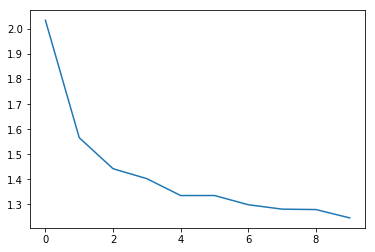

In [124]:
plt.plot(total_loss)

In [145]:
import pandas as pd
confusion_matrix = pd.DataFrame(columns=languages, index=languages, dtype=np.int64)
confusion_matrix

,Czech,German,Arabic,Japanese,Chinese,Vietnamese,Russian,French,Irish,English,Spanish,Greek,Italian,Portuguese,Scottish,Dutch,Korean,Polish
Czech,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
German,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Arabic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Japanese,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Chinese,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Vietnamese,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Russian,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
French,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Irish,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
English,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


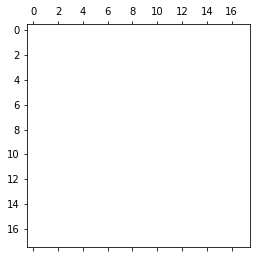

In [146]:
plt.matshow(confusion_matrix)

In [149]:
with torch.no_grad():
    class_total = list(range(n_classes))
    correct_class = list(range(n_classes))
    for language in valid_data.keys():
        for name in valid_data[language]:
            name_tensor = name_to_tensor(name, vocab_size)
            hidden_state = rnn.initialize_hidden_state()
            for char in name_tensor:
                output, hidden_state = rnn(char, hidden_state)
            pred = languages[torch.argmax(output)]
            label_idx = languages.index(language)
            class_total[label_idx] += 1 
            correct_class[label_idx] += language == pred
            confusion_matrix.loc[language, pred] += 1

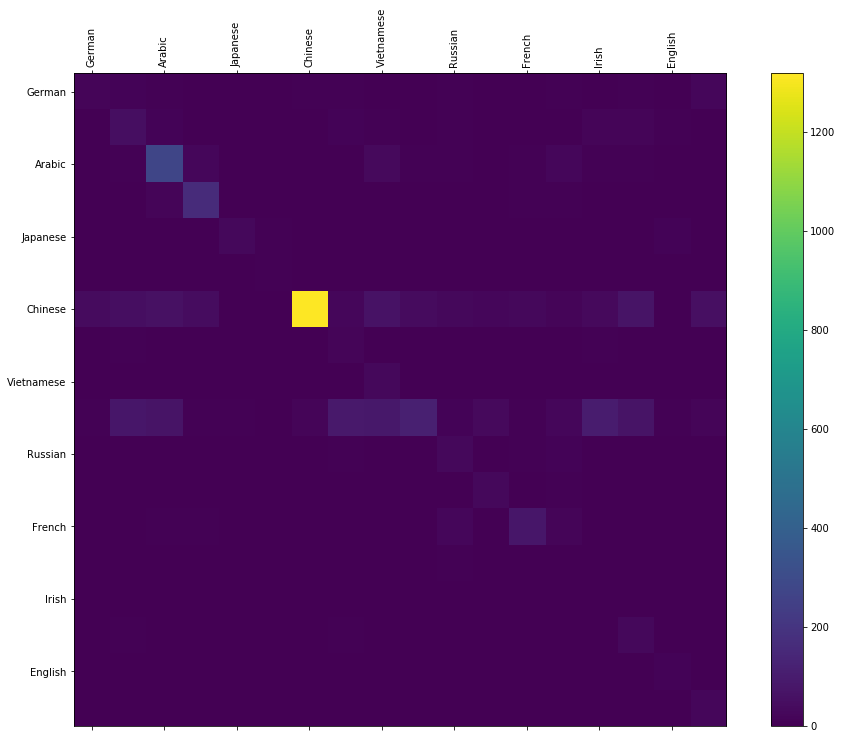

In [172]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
cax = ax.matshow(confusion_matrix.fillna(0))
fig.colorbar(cax)
ax.set_xticklabels(languages, rotation=90)
ax.set_yticklabels(languages);

In [139]:
print(f'Overall Accuracy : {sum(correct_class) / sum(class_total):.2%}')

Overall Accuracy : 56.64%


In [137]:
for i, class_ in enumerate(languages):
    acc = correct_class[i] / class_total[i]
    print(f'Accuracy of {class_:<10} : {acc:.2%}, '\
          f'Training Size : {len(language_names[class_])}')

Accuracy of Czech      : 16.35%, Training Size : 519
Accuracy of German     : 34.93%, Training Size : 724
Accuracy of Arabic     : 68.91%, Training Size : 2000
Accuracy of Japanese   : 80.69%, Training Size : 991
Accuracy of Chinese    : 50.00%, Training Size : 268
Accuracy of Vietnamese : 50.00%, Training Size : 73
Accuracy of Russian    : 70.13%, Training Size : 9408
Accuracy of French     : 38.10%, Training Size : 277
Accuracy of Irish      : 63.64%, Training Size : 232
Accuracy of English    : 16.69%, Training Size : 3668
Accuracy of Spanish    : 54.29%, Training Size : 298
Accuracy of Greek      : 75.00%, Training Size : 203
Accuracy of Italian    : 57.79%, Training Size : 709
Accuracy of Portuguese : 60.71%, Training Size : 74
Accuracy of Scottish   : 52.94%, Training Size : 100
Accuracy of Dutch      : 58.67%, Training Size : 297
Accuracy of Korean     : 77.14%, Training Size : 94
Accuracy of Polish     : 84.44%, Training Size : 139


# RNN - V1

In [174]:
class RNN(nn.Module):
    '''Creating one hidden layer RNN.'''
    
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.input_to_hidden = nn.Linear(self.input_size + self.hidden_size,
                                         self.hidden_size)
        self.hidden_to_output = nn.Linear(self.hidden_size, self.output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, input_word, hidden_state):
        combined = torch.cat([hidden_state, input_word], 1)
        hidden_state = F.tanh(self.input_to_hidden(combined))
        output = self.hidden_to_output(hidden_state)
        output = self.softmax(output)
        return output, hidden_state
    
    def initialize_hidden_state(self):
        return torch.zeros(1, self.hidden_size)

In [175]:
# Instantiate the model
hidden_size = 128
rnn = RNN(vocab_size, hidden_size, n_classes)

# Loss and optimizer
criterion = nn.NLLLoss()
optimizer = optim.Adam(rnn.parameters())

In [176]:
n_iterations = 100000
start = time.time()
total_loss = []
current_loss = 0
for i in range(n_iterations):
    # Initialize hidden state to zero
    hidden_state = rnn.initialize_hidden_state()
    
    # Get name and label tensors
    _, _, name_tensor, label_tensor = names_dataloader(training_data, vocab_size)
    
    # Zeros gradients
    optimizer.zero_grad()
    
    # Iterate over all characters in name
    for char in name_tensor:
        output, hidden_state = rnn(char, hidden_state)
    
    loss = criterion(output, label_tensor)
    current_loss += loss
    
    # Compute gradients
    loss.backward()
    
    # Update weights
    optimizer.step()
    
    if (i + 1) % 5000 == 0:
        print(f'Iteration : {i + 1:>6}, Loss : {loss:.3f}.')
    
    if (i + 1) % 10000 == 0:
        total_loss.append(current_loss / 10000)
        current_loss = 0

Iteration :   5000, Loss : 0.019.
Iteration :  10000, Loss : 1.844.
Iteration :  15000, Loss : 0.541.
Iteration :  20000, Loss : 0.247.
Iteration :  25000, Loss : 0.035.
Iteration :  30000, Loss : 0.183.
Iteration :  35000, Loss : 0.029.
Iteration :  40000, Loss : 0.862.
Iteration :  45000, Loss : 0.265.
Iteration :  50000, Loss : 0.681.
Iteration :  55000, Loss : 0.174.
Iteration :  60000, Loss : 0.131.
Iteration :  65000, Loss : 1.947.
Iteration :  70000, Loss : 1.726.
Iteration :  75000, Loss : 5.111.
Iteration :  80000, Loss : 0.007.
Iteration :  85000, Loss : 0.065.
Iteration :  90000, Loss : 0.107.
Iteration :  95000, Loss : 0.725.
Iteration : 100000, Loss : 0.000.


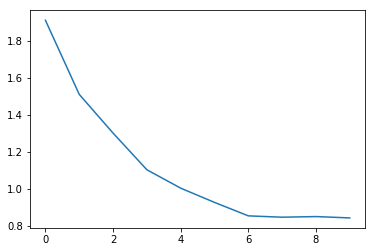

In [177]:
plt.plot(total_loss)

In [178]:
with torch.no_grad():
    class_total = list(range(n_classes))
    correct_class = list(range(n_classes))
    for language in valid_data.keys():
        for name in valid_data[language]:
            name_tensor = name_to_tensor(name, vocab_size)
            hidden_state = rnn.initialize_hidden_state()
            for char in name_tensor:
                output, hidden_state = rnn(char, hidden_state)
            pred = languages[torch.argmax(output)]
            label_idx = languages.index(language)
            class_total[label_idx] += 1 
            correct_class[label_idx] += language == pred
            confusion_matrix.loc[language, pred] += 1

In [179]:
print(f'Overall Accuracy : {sum(correct_class) / sum(class_total):.2%}')

Overall Accuracy : 60.25%


In [180]:
for i, class_ in enumerate(languages):
    acc = correct_class[i] / class_total[i]
    print(f'Accuracy of {class_:<10} : {acc:.2%}, '\
          f'Training Size : {len(language_names[class_])}')

Accuracy of Czech      : 36.54%, Training Size : 519
Accuracy of German     : 47.26%, Training Size : 724
Accuracy of Arabic     : 80.35%, Training Size : 2000
Accuracy of Japanese   : 80.20%, Training Size : 991
Accuracy of Chinese    : 74.14%, Training Size : 268
Accuracy of Vietnamese : 70.00%, Training Size : 73
Accuracy of Russian    : 73.52%, Training Size : 9408
Accuracy of French     : 47.62%, Training Size : 277
Accuracy of Irish      : 58.18%, Training Size : 232
Accuracy of English    : 16.15%, Training Size : 3668
Accuracy of Spanish    : 52.86%, Training Size : 298
Accuracy of Greek      : 71.15%, Training Size : 203
Accuracy of Italian    : 55.84%, Training Size : 709
Accuracy of Portuguese : 53.57%, Training Size : 74
Accuracy of Scottish   : 61.76%, Training Size : 100
Accuracy of Dutch      : 56.00%, Training Size : 297
Accuracy of Korean     : 60.00%, Training Size : 94
Accuracy of Polish     : 82.22%, Training Size : 139


# RNN - Two Layers

In [207]:
class RNN(nn.Module):
    '''Creating one hidden layer RNN.'''
    
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.input_to_hidden = nn.Linear(self.input_size + self.hidden_size,
                                         self.hidden_size)
        self.hidden_to_hidden = nn.Linear(self.hidden_size, self.hidden_size)
        self.hidden_to_output = nn.Linear(self.hidden_size, self.output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, input_word, hidden_state):
        combined = torch.cat([hidden_state, input_word], 1)
        hidden_state = F.tanh(self.input_to_hidden(combined))
        hidden_state = F.tanh(hidden_state)
        output = self.hidden_to_output(hidden_state)
        output = self.softmax(output)
        return output, hidden_state
    
    def initialize_hidden_state(self):
        return torch.zeros(1, self.hidden_size)

In [208]:
# Instantiate the model
hidden_size = 128
rnn = RNN(vocab_size, hidden_size, n_classes)

# Loss and optimizer
criterion = nn.NLLLoss()
optimizer = optim.Adam(rnn.parameters())

In [209]:
n_iterations = 100000
start = time.time()
total_loss = []
current_loss = 0
for i in range(n_iterations):
    # Initialize hidden state to zero
    hidden_state = rnn.initialize_hidden_state()
    
    # Get name and label tensors
    _, _, name_tensor, label_tensor = names_dataloader(training_data, vocab_size)
    
    # Zeros gradients
    optimizer.zero_grad()
    
    # Iterate over all characters in name
    for char in name_tensor:
        output, hidden_state = rnn(char, hidden_state)
    
    loss = criterion(output, label_tensor)
    current_loss += loss
    
    # Compute gradients
    loss.backward()
    
    # Update weights
    optimizer.step()
    
    if (i + 1) % 5000 == 0:
        print(f'Iteration : {i + 1:>6}, Loss : {loss:.3f}.')
    
    if (i + 1) % 10000 == 0:
        total_loss.append(current_loss / 10000)
        current_loss = 0

Iteration :   5000, Loss : 1.565.
Iteration :  10000, Loss : 2.224.
Iteration :  15000, Loss : 0.918.
Iteration :  20000, Loss : 0.113.
Iteration :  25000, Loss : 2.218.
Iteration :  30000, Loss : 0.567.
Iteration :  35000, Loss : 2.698.
Iteration :  40000, Loss : 3.825.
Iteration :  45000, Loss : 0.050.
Iteration :  50000, Loss : 1.125.
Iteration :  55000, Loss : 0.040.
Iteration :  60000, Loss : 3.141.
Iteration :  65000, Loss : 0.148.
Iteration :  70000, Loss : 0.108.
Iteration :  75000, Loss : 0.999.
Iteration :  80000, Loss : 0.055.
Iteration :  85000, Loss : 0.071.
Iteration :  90000, Loss : 1.260.
Iteration :  95000, Loss : 0.056.
Iteration : 100000, Loss : 1.421.


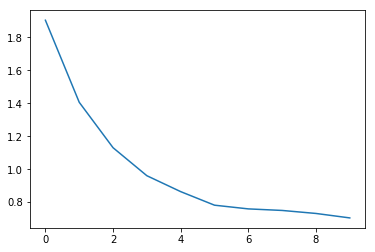

In [210]:
plt.plot(total_loss)

In [211]:
with torch.no_grad():
    class_total = list(range(n_classes))
    correct_class = list(range(n_classes))
    for language in valid_data.keys():
        for name in valid_data[language]:
            name_tensor = name_to_tensor(name, vocab_size)
            hidden_state = rnn.initialize_hidden_state()
            for char in name_tensor:
                output, hidden_state = rnn(char, hidden_state)
            pred = languages[torch.argmax(output)]
            label_idx = languages.index(language)
            class_total[label_idx] += 1 
            correct_class[label_idx] += language == pred
            confusion_matrix.loc[language, pred] += 1

In [212]:
print(f'Overall Accuracy : {sum(correct_class) / sum(class_total):.2%}')

Overall Accuracy : 62.79%


In [213]:
for i, class_ in enumerate(languages):
    acc = correct_class[i] / class_total[i]
    print(f'Accuracy of {class_:<10} : {acc:.2%}, '\
          f'Training Size : {len(language_names[class_])}')

Accuracy of Czech      : 35.58%, Training Size : 519
Accuracy of German     : 42.47%, Training Size : 724
Accuracy of Arabic     : 81.84%, Training Size : 2000
Accuracy of Japanese   : 73.27%, Training Size : 991
Accuracy of Chinese    : 67.24%, Training Size : 268
Accuracy of Vietnamese : 50.00%, Training Size : 73
Accuracy of Russian    : 73.73%, Training Size : 9408
Accuracy of French     : 55.56%, Training Size : 277
Accuracy of Irish      : 67.27%, Training Size : 232
Accuracy of English    : 32.44%, Training Size : 3668
Accuracy of Spanish    : 42.86%, Training Size : 298
Accuracy of Greek      : 80.77%, Training Size : 203
Accuracy of Italian    : 64.29%, Training Size : 709
Accuracy of Portuguese : 46.43%, Training Size : 74
Accuracy of Scottish   : 47.06%, Training Size : 100
Accuracy of Dutch      : 44.00%, Training Size : 297
Accuracy of Korean     : 68.57%, Training Size : 94
Accuracy of Polish     : 75.56%, Training Size : 139
